# Set up

In [1]:
#load in libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras import  backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding


#load data files 
test = pd.read_csv("../input/digit-recognizer/test.csv")
train = pd.read_csv("../input/digit-recognizer/train.csv")
sample_submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

Look at structure of each dataset. Pixel intensities are represented as integers from 1 to 255. 1 is the lightest value while 255 is the darkest value. Each image is 28 pixels wide x 28 pixels long = 784 pixels in total. The label value gives the digit which each drawing represents.

In [2]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sample_submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


# Data visualization

Visualize data. Plot a sample of every digit.

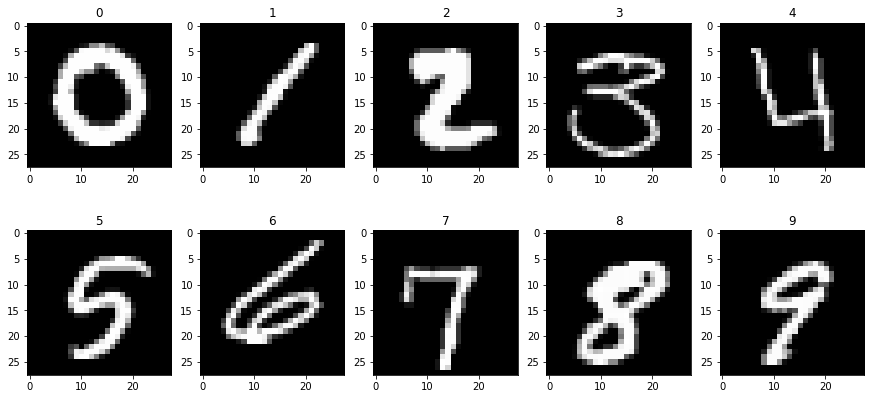

In [5]:
train_pixels = train.drop(columns=['label'],axis=1).to_numpy().reshape(-1,28,28)
train_pixels.shape

plt.figure(figsize=(15,7))
for digit in range(0, 10):
    #find first indice where training data equals digit
     index = np.where(train['label'] == digit)[0][0]
     plt.subplot(2,5,digit + 1)
     plt.title(digit)
     plt.imshow(train_pixels[index], cmap='gray')

Look at distribution of digits in dataset. 

[Text(0.5, 1.0, 'Digit counts'), Text(0.5, 0, 'Digit'), Text(0, 0.5, 'Count')]

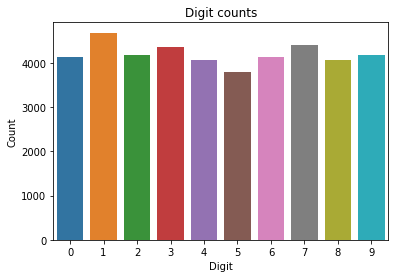

In [6]:
sns.countplot(x = train["label"]).set(title = "Digit counts", xlabel = "Digit", ylabel = "Count")


Training dataset seems to be fairly balanced between digits, though 1 is the most common digit.

# Data preparation

This dataset appears to be very clean and leads minimal processing. It would be helpful to normalize each pixel value to 0-1 before running neural network model. Currently, each pixel value ranges from 0 to 255 so an divide by 255. Use float type to convert values to float.

In [7]:
train_normalized = train.copy()
pixel_cols = train_normalized.drop('label', axis =1).columns
train_normalized[pixel_cols] = train_normalized[pixel_cols].apply(lambda x: x/255.0)
test_normalized = test/255.0

Split training data into training and validation sets. Put 75% of data into training set, 25% in validation. Make sure the proportion of digits is the same in training and validation sets.

In [8]:
X = train_normalized.copy()
y = X.pop('label') #take out label from X, move to y
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

# Modelling

Initialize deep neural network model. Input shape is 784 since since 784 pixel variables. Use batch normalization function to standardize data going into each activation function. Large amount of data so use 100 neurons for middle two layers in network. Use softmax activation function to convert output to probabilities of image being of each digit. Add early stopping functino to prevent overfitting.

In [9]:
model = keras.Sequential([
    layers.Dense(784, activation='relu', input_shape=[784]),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax'),
])
#use standard adam optimizer, sparse categorical cross entropy to measure loss, accuracy as metric
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

#early stopping function, to make sure function does not overfit
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
)

2022-09-17 22:49:39.744937: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Print out model summary.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 1,027,674
Trainable params: 1,025,082
Non-trainable params: 2,592
_________________________________________________________________


Fit model to digits data. Use large batch size and epochs values, but incldue early stopping to avoid overfitting.

In [11]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    callbacks = [early_stopping],
    epochs=20,
    verbose=0,
)

2022-09-17 22:49:40.599871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Calculate evaluation statistics to measure model performance.

In [12]:
model.evaluate(X_valid, y_valid)

329/329 [==============================] - 1s 2ms/step - loss: 0.1244 - accuracy: 0.9764


[0.1244497150182724, 0.9763809442520142]

Look at learning curves for model prediction.

Best Validation Loss: 0.0937
Best Validation Accuracy: 0.9793


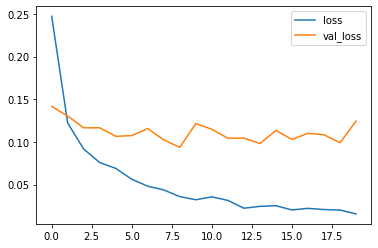

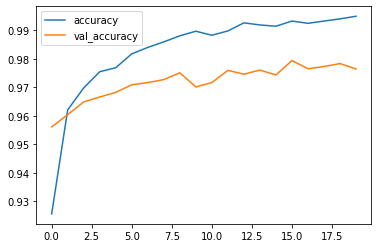

In [13]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# CNN model

Try running convolutional neural networks model, which are efficient for image processing.

In [14]:

model = Sequential([
    layers.Convolution2D(32,(3,3), activation='relu', input_shape = (28, 28, 1)),
    layers.BatchNormalization(axis=1),
    layers.Convolution2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(axis=1),
    layers.Convolution2D(64,(3,3), activation='relu'),
    layers.BatchNormalization(axis=1),
    layers.Convolution2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
    ])

model.compile(optimizer = "adam", loss='categorical_crossentropy',
                  metrics=['accuracy'])
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
)


Transofmr data for input into convolutional neural networks model. Need data to be in shape (batch_size, height, width, depth) so (31500 observations, 28 rows, 28 rows, 1 black/white scale). 

In [15]:
X_train_expanded = X_train.to_numpy().reshape(-1, 28, 28, 1)
X_valid_expanded = X_valid.to_numpy().reshape(-1, 28, 28, 1)
test_expanded = test.to_numpy().reshape(-1, 28, 28, 1)


One-hot encode labels since values we are trying to predict are finite digits.

In [16]:
y_train = to_categorical(y_train, num_classes = 10)
y_valid = to_categorical(y_valid, num_classes = 10)

In [17]:
history = model.fit(
    X_train_expanded, y_train,
    validation_data=(X_valid_expanded, y_valid),
    epochs=5,
    verbose=0,
)



In [18]:
model.evaluate(X_valid_expanded, y_valid)

329/329 [==============================] - 3s 10ms/step - loss: 0.0431 - accuracy: 0.9868


[0.04305548593401909, 0.9867619276046753]

Best Validation Loss: 0.0431
Best Validation Accuracy: 0.9868


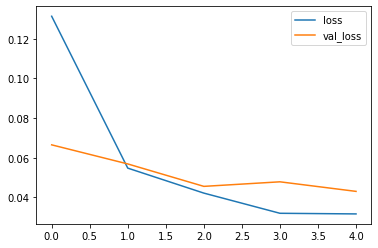

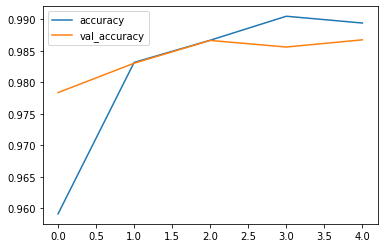

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

# Add more images to training dataset to fine tune model

Convolutional neural network model has a higher training and validation score than the simpler deep neural network model. I will add more images to the training dataset to improve the score further.

In [20]:
gen = image.ImageDataGenerator()
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train_expanded, y_train, batch_size=64)
val_batches = gen.flow(X_valid_expanded, y_valid, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


31500/31500 [==============================] - 45s 1ms/step - loss: 0.0636 - accuracy: 0.9810 - val_loss: 0.0553 - val_accuracy: 0.9839


# Use model to make predictions and submit

Calculate predictions.

In [21]:
#model.predict df has 10 columns, each representing a digit and probability 
#return digit with highest probability for each row
preds = np.argmax(model.predict(test_expanded), axis = 1)
preds


array([2, 0, 9, ..., 3, 9, 2])

View predictions on random sample of nine images to confirm model working as expected.

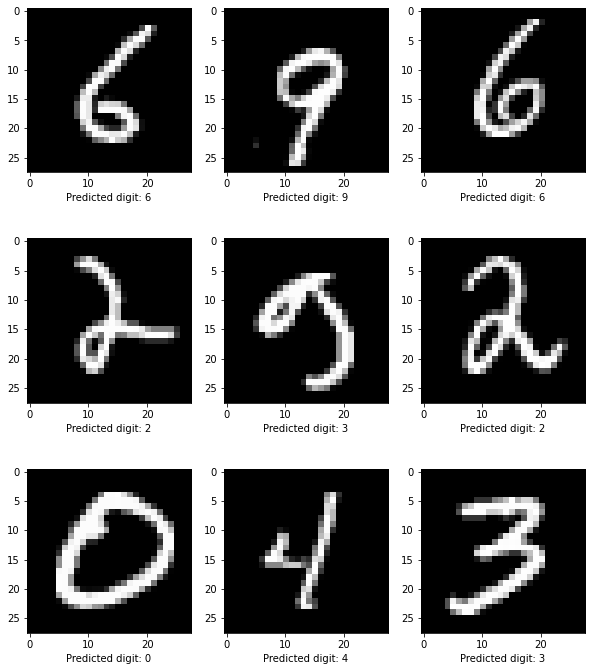

In [22]:
import random
test_pixels = test.to_numpy().reshape(len(test),28,28)
plt.figure(figsize=(10,12))
for index, row_num in enumerate(random.sample(range(0,len(test)), 9), start=1):
    plt.subplot(3,3,index)
    #add images to plot
    img_data = test_pixels[row_num]
    plt.imshow(img_data, cmap='gray')
    #add prediction to plot
    plt.xlabel('Predicted digit: ' + str(preds[row_num]))



Output predictions for submission to competition.

In [23]:
output = pd.DataFrame({'ImageId': test.index+1, 'Label': preds})
output.to_csv('submission.csv',index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
